# import

In [1]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load

In [2]:
cfg = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

In [3]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

C:\ProgramData\anaconda3\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55903 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:55903/status,
Dashboard: http://127.0.0.1:55903/status,Workers: 4
Total threads: 16,Total memory: 7.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55904,Workers: 4
Dashboard: http://127.0.0.1:55903/status,Total threads: 16
Started: Just now,Total memory: 7.73 GiB
Comm: tcp://127.0.0.1:55951,Total threads: 4
Dashboard: http://127.0.0.1:55952/status,Memory: 1.93 GiB
Nanny: tcp://127.0.0.1:55909,


In [36]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2022-06-01/2022-07-01",
    query={"s2:mgrs_tile": dict(eq="32TPP")}, #06VVN -alaska #31UDQ -france
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 12 datasets


C:\Users\adham.ahmed\AppData\Roaming\Python\Python310\site-packages\pystac_client\item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [37]:
resolution = 10
SHRINK = 4
if client.cluster.workers[0].memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
    resolution=resolution,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


C:\ProgramData\anaconda3\lib\site-packages\distributed\worker_memory.py:424: FutureWarning: The `Nanny.memory_limit` attribute has been moved to `Nanny.memory_manager.memory_limit
  warnings.warn(


<xarray.Dataset>
Dimensions:      (y: 1374, x: 1373, time: 12)
Coordinates:
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2022-06-02T10:05:59.024000 ... 2022-06...
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>

In [38]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir,SCL


<xarray.Dataset>
Dimensions:      (y: 1374, x: 1373, time: 12)
Coordinates:
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2022-06-02T10:05:59.024000 ... 2022-06...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 1374, 1373), meta=np.ndarray>

In [39]:
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)


def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

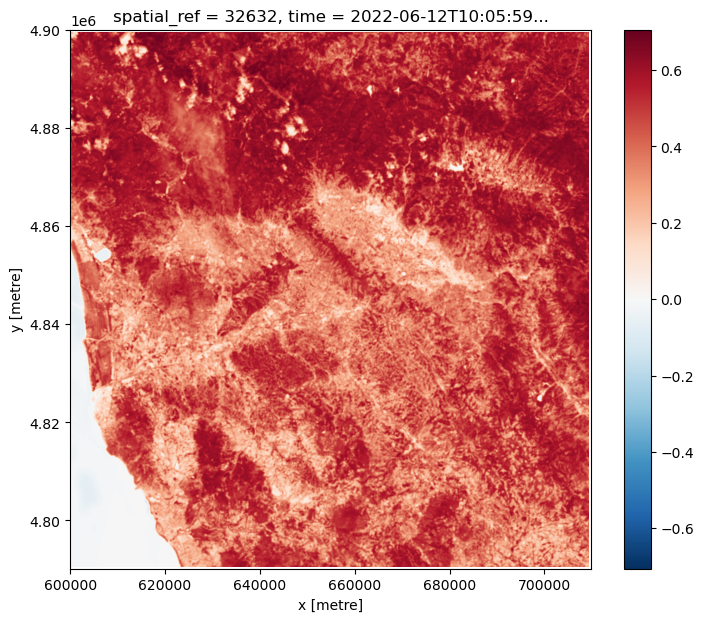

In [40]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")